# The following Notebook simulates the LRGs mono/quadrupole galaxy power spectrum at different z bins for a J-PAS forecast, for different specifications of the catalogue and different primordial power spectrum feature templates #

In [138]:
#Sections with * indicate that they should be modify if catalogue specifications are changed

#Sections with ** indicate that the path or output filenames must be modified according to the desired specifications

# Packages to be loaded** #

In [139]:
#Packages to be loaded

import cobaya
import sys
#Specify in this path where your CAMB is installed**
sys.path.append('/Users/guillermo/Desktop/code/CAMB')
import camb
import numpy as np
import sympy
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter
from scipy.special import erf
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import scipy.integrate as integrate

# k and z binning for the J-PAS spectra #

In [140]:
#Scale and redshift bins arrays limits and steps. 

#Extended arrays are also calculated.

#k array limits, in h Mpc{-1} units: 
khminKhArrayJPASComplete = 0.001;   khmaxKhArrayJPASComplete = 2.4900;  stepKhArrayJPASComplete = 0.025;

#k binning, complete and in a reduced scaleset. In h Mpc{-1}:
KhArrayJPASComplete = np.exp(np.arange(math.log(khminKhArrayJPASComplete), math.log(khmaxKhArrayJPASComplete), stepKhArrayJPASComplete) )
KhArrayJPAS = KhArrayJPASComplete[range(120,212)]

#k binning on lower and upper limits
KhArrayJPASUpper = np.zeros(len(KhArrayJPAS)); KhArrayJPASLower = np.zeros(len(KhArrayJPAS));

for i in range(0, len(KhArrayJPAS)-1):
    KhArrayJPASUpper[i] = KhArrayJPAS[i] + (KhArrayJPAS[i+1]-KhArrayJPAS[i])/2;
    KhArrayJPASLower[i] = KhArrayJPAS[i] - (KhArrayJPAS[i+1]-KhArrayJPAS[i])/2;

#The last element of KUpper or KLower can be problematic. We copy the last element into the penultimate position
KhArrayJPASUpper[-1] = KhArrayJPASUpper[-2];  KhArrayJPASLower[-1] = KhArrayJPASLower[-2];

#z binning for high-z
zJPASmin = 0.1;   zJPASmax = 0.9;   stepzJPAS = 0.2;

#Original z-bin array
zJPASPrevious = np.arange(zJPASmin, zJPASmax+stepzJPAS/2, stepzJPAS)

#Binning including all lower and upper z-bins limits and 0 bin
zJPAS = np.arange(zJPASmin-stepzJPAS/2, zJPASmax+0.01+stepzJPAS/2, stepzJPAS/2)

#Positions of upper and lower limits of the z-bins in the z array
positions_Upper = [2, 4, 6, 8, 10]
positions_Lower = [0, 2, 4, 6, 8]

# Fiducial cosmology: parameters #

In [141]:
#Cosmological constants:
c = 2.99792458E5;   H = 1/(c/100);

#Parameteres that won't be sampled:
OmegakJPAS = 0;    gamma = 0.545;     kPivot = 0.05 #Mpc{-1}

#Baseline fixed cosmology fromPlanck 2018-values TT+TE+EE+lowE+lensing. Neutrinos are assumed as 0 mass:
AsJPAS = 2.09052E-9; nsJPAS = 0.9646; tauJPAS = 0.0544; mnuJPAS = 0.0; nmuJPAS = 3.046;

#Fiducial for the baseline cosmological parameters that are going to be sampled:
hJPAS = 0.6737
OmegabJPASh2 = 0.02237
OmegaCDMJPASh2 = 0.1200

#Indirect cosmological parameters:
H0JPAS = hJPAS*100
OmegabJPAS = OmegabJPASh2/hJPAS**2;   OmegaCDMJPAS = OmegaCDMJPASh2/hJPAS**2;

# Rest of cosmology obtained from CAMB #

In [142]:
#We calculate the rest of the cosmology with CAMB, including the linear matter power spectrum#

In [143]:
#We create the variable with the CAMB input params:
parsJPAS = camb.CAMBparams()

#We provide our fiducial baseline cosmology to CAMB as input:
parsJPAS.set_cosmology(H0=H0JPAS, ombh2=OmegabJPASh2, omch2=OmegaCDMJPASh2, tau=tauJPAS, omk=OmegakJPAS, mnu=mnuJPAS)

#The power spectrum parameters are also given as input. Not interested in tensorial part, thus r=0:
parsJPAS.InitPower.set_params(As=AsJPAS, ns=nsJPAS, r=0)

#For calculating the matter power spectrum. We employ our z-bins and set the kmax of 1000 h Mpc^{-1} 
parsJPAS.set_matter_power(redshifts=zJPAS, kmax=1000*hJPAS); #Reads Mpc{-1}, thus the hJPAS factor

Note: redshifts have been re-sorted (earliest first)


In [144]:
#CAMB results:
resultsJPAS = camb.get_results(parsJPAS)

In [145]:
#CAMB matter power spectrum with h^3 units (hubble_units) at scales k with h Mpc{-1} units (k_hunit):
khJPASCAMB,zsJPASCAMB,PKJPASCAMB = resultsJPAS.get_linear_matter_power_spectrum(hubble_units=True,k_hunit=True)

In [146]:
#CAMB transfer functions:
transJPAS = resultsJPAS.get_matter_transfer_data()

#Total transfer function for each z bin:
TransTotJPAS = np.zeros((len(zJPAS), len(transJPAS.transfer_data[6])))

for iz in range(0, len(zJPAS)):
    for j in range(0, len(transJPAS.transfer_data[6])):
        TransTotJPAS[iz][j] = transJPAS.transfer_data[6,j,-iz-1] #This column reads the total transfer function.

#Linear interpolation of the transfer function at the kh where the matter power spectrum is calculated.
TransTotJPASEnKArray =  np.zeros((len(zJPAS), len(transJPAS.transfer_data[6])))

for iz in range(len(zJPAS)):
    TransTotJPASInterpolation = interp1d(khJPASCAMB, TransTotJPAS[iz], kind='linear')
    for j in range(0, len(KhArrayJPAS)):
        TransTotJPASEnKArray[iz][j] = TransTotJPASInterpolation(KhArrayJPAS[j])


In [147]:
#Cosmological parameters and functions obtained from CAMB at the fiducial cosmology:

#Omega_m:
OmegamJPASFid = resultsJPAS.get_Omega('baryon')+resultsJPAS.get_Omega('cdm')

#Dimensionless Hubble function:
EzJPASFid = np.sqrt(OmegamJPASFid*(1+zJPAS)**3+(1-OmegamJPASFid))

#Hubble function with units:
HJPAS = H * EzJPASFid

#Growth function:
fJPASFid = (OmegamJPASFid*(1+zJPAS)**3*1/(EzJPASFid**2))**gamma

#Comoving and angular distances. In Mpc{-1}, without h units (thus the h factor):
XiJPASFid = resultsJPAS.angular_diameter_distance(zJPAS)*(1+zJPAS)*hJPAS
DAJPASFid = XiJPASFid/(1+zJPAS)

#Growth Factor. It is calculated by comparing the mean over k values of P_m(k,z)/P_m(k,0) of all the z given to CAMB:
DzJPASFid = np.array([np.mean(PKJPASCAMB[x]/PKJPASCAMB[0])**0.5 for x in range(len(zsJPASCAMB))])

#Fingers of God parameters. Dispersion of velocities:
sigmapJPASFid = (1/(6*np.pi**2))**0.5*np.trapz(PKJPASCAMB, khJPASCAMB)**0.5

# LSS specific quantities for the J-PAS forecast* ** #

In [148]:
#Bias model for the LRGs (low-z) objects. We employ the Resco-Maroto one*:
bLRGJPAS = 1.70/DzJPASFid

In [149]:
#Densities n(z) and photometric erorrs Delta_z of LRGs at each z-bin.

#Path where the table with the densities and delta_z are located for the LRGs and a certain tray strategy**:
file_path = '/Users/guillermo/Desktop/J-PAS_Forecast_Data/Densities Mini J-PAS Antonio Maroto/nlrg_12_lowdeltaz_per_bin_no_header.tex'

# Read the file using pandas, skipping the first row which contains the header
data = pd.read_csv(file_path, sep='\s+', header=None, usecols=[0, 1, 2], skiprows=0)

#Asign the z-bins and densities as the first and second columns:
znLRGsJPAS = data[0].values 
nLRGsJPAS = data[1].values #Units of (Mpc/h)^3
DeltazLRGJPASPrevious = data[2].values #Delta_z, no factor 1/(1+z)

#Create an array that includes the photometric error in the extended z-bin elements: 
DeltazLRGJPAS = np.zeros(len(zJPAS))

for i in range(len(DeltazLRGJPASPrevious)):
    DeltazLRGJPAS[2*i + 1] = DeltazLRGJPASPrevious[i]

In [150]:
#Time of observation in years*:

#ObservationTime = 2.5 #Quarter J-PAS mission
ObservationTime = 5 #Half J-PAS mission
#ObservationTime = 10 #Full J-PAS mission

In [151]:
#Area of the sky covered. It is calculated from the ObservationTime and the TrayFilterNumber unambiguously.

#Area of the sky in sq degrees per year for each tray strategy:
AreaPerYear2TrayFilters = 900
AreaPerYear4TrayFilters = 450

#Total area the sky in sq degrees*:
#Asky = AreaPerYear4TrayFilters * ObservationTime
Asky = AreaPerYear2TrayFilters * ObservationTime

#Conversion to fraction of the sky, fsky:
def fsky(Asky):
    return Asky/(4*np.pi*(180/np.pi)**2)

#Values of fsky
fskyJPAS = fsky(Asky)

#Check the Asky (sq degrees) and fsky values:
Asky,fskyJPAS

(4500, 0.10908307824964558)

# Primordial power spectrum templates #

In [152]:
#We create the different templates for the primordial power spectrum:
#   - Power Law (Standard Model): includes the parameters A_s and n_s, and a kPivot
#   - Local Feature Template: includes the Local Bump feature (LB) and the Local Oscillatory (LO) feature
#         - The local oscillatory feature has 3 templates: of 10% amplitude (by default LO), 3% amplitude (LO3) and 1% amplitude (LO1)
#   - Global Feature template.
#         - Includes 3 templates, with 10%, 2.5% and 1.25% amplitudes.

# Power Law #

In [153]:
#We start with the Standard Model's power law:

In [154]:
#Power law primordial power spectrum. Scale k must be in h Mpc{-1}:
def PrimordialPowerLaw(As,ns,k):
    return As*(k/(kPivot/hJPAS))**(ns-1)

In [155]:
#Power law primordial power spectrum in just Mpc^{-1} units:
def PrimordialPowerLawNoh(As,ns,k):
    return As*(k/(kPivot))**(ns-1)

# Local Feature Template #

In [156]:
#We start defyning the common window functions:

def W1_0(x):
    return (1 / (2 * x**3)) * ((18 * x - 6 * x**3) * np.cos(2 * x) + (15 * x**2 - 9) * np.sin(2 * x))

def W2_0(x):
    return (3 / (2 * x**3)) * (np.sin(2 * x) - 2 * x * np.cos(2 * x) - x**2 * np.sin(2 * x))

def W3_0(x):
    return (1 / x**3) * (6 * x * np.cos(2 * x) + (4 * x**2 - 3) * np.sin(2 * x))

def W1_1(x):
    return -(1 / x**3) * (3 * (x * np.cos(x) - np.sin(x)) * (3 * x * np.cos(x) + (2 * x**2 - 3) * np.sin(x)))

def W2_1(x):
    return (3 / x**3) * (np.sin(x) - x * np.cos(x))**2

def W3_1(x):
    return -(1 / x**3) * (3 + 2 * x**2 - (3 - 4 * x**2) * np.cos(2 * x) - 6 * x * np.sin(2 * x))

In [157]:
#Damping function:
def Dam(x):
    return x/np.sinh(x)

In [158]:
#Perturbation terms:
def I0(A1,A2,A3,k,ks,xs):
    return (A1 * W1_0(k/ks) + A2 *W2_0(k/ks) + A3 * W3_0(k/ks)) * Dam(k/(ks*xs))

def I1(A1,A2,A3,ns,k,ks,xs):
    return (1 / np.sqrt(2)) * (np.pi / 2 * (1 - ns) + (A1 * W1_1(k/ks) + A2 * W2_1(k/ks) + A3 * W3_1(k/ks)) * Dam(k/(ks*xs))) - (1 / np.sqrt(2)) * (np.pi / 2 * (1 - ns)  )              

In [159]:
#Generic local feature template:
def LogPrimordialLocalFeature(A1,A2,A3,As,ns,k,ks,xs):
    return np.log(PrimordialPowerLawNoh(As,ns,k)) + I0(A1,A2,A3,k,ks,xs) + np.log(1+ I1(A1,A2,A3,ns,k,ks,xs)**2)    

In [160]:
#Parameters for the local bump feature:
A1LBump = 2.0; A2LBump = 0.0; A3LBump = 0.1;
ksLBump = 1.05*hJPAS; xsLBump = 0.5;

In [161]:
#Parameters for the local oscillatory feature (10% amplitude by default):
A1LOsci = 1.8; A2LOsci = 0.0; A3LOsci= 0.7;
ksLOsci = 0.15*hJPAS; xsLOsci = 0.3;

In [162]:
#Parameters for the local oscillatory feature (3% amplitude):
A1LO3sci = 1.8/4; A2LO3sci = 0.0; A3LO3sci= 0.7/7;
ksLO3sci = 0.14*hJPAS; xsLO3sci = 0.3;

In [163]:
#Parameters for the local oscillatory feature (1% amplitude):
A1LO1sci = 1.8/12; A2LO1sci = 0.0; A3LO1sci= 0.7/21;
ksLO1sci = 0.14*hJPAS; xsLO1sci = 0.3;

In [164]:
#Local bump feature function:
def PrimordialLocalBumpFeature(k):
    return np.exp(LogPrimordialLocalFeature(A1LBump,A2LBump,A3LBump,AsJPAS,nsJPAS,k,ksLBump,xsLBump))

In [165]:
#Local oscillatory feature function (default 10% amplitude):
def PrimordialLocalOscillatoryFeature(k):
    return np.exp(LogPrimordialLocalFeature(A1LOsci,A2LOsci,A3LOsci,AsJPAS,nsJPAS,k,ksLOsci,xsLOsci))

In [166]:
#Local oscillatory feature function (3% amplitude):
def PrimordialLocalOscillatory3Feature(k):
    return np.exp(LogPrimordialLocalFeature(A1LO3sci,A2LO3sci,A3LO3sci,AsJPAS,nsJPAS,k,ksLO3sci,xsLO3sci))

In [167]:
#Local oscillatory feature function (1% amplitude):
def PrimordialLocalOscillatory1Feature(k):
    return np.exp(LogPrimordialLocalFeature(A1LO1sci,A2LO1sci,A3LO1sci,AsJPAS,nsJPAS,k,ksLO1sci,xsLO1sci))

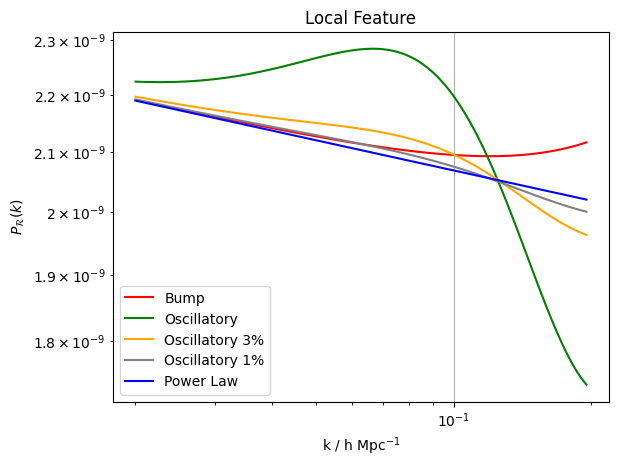

In [168]:
#Figure plotting all the local feature templates:

plt.loglog(KhArrayJPAS,PrimordialLocalBumpFeature(KhArrayJPAS*hJPAS), color='red', label='Bump')
plt.loglog(KhArrayJPAS,PrimordialLocalOscillatoryFeature(KhArrayJPAS*hJPAS), color='green', label='Oscillatory')
plt.loglog(KhArrayJPAS,PrimordialLocalOscillatory3Feature(KhArrayJPAS*hJPAS), color='orange', label='Oscillatory 3%')
plt.loglog(KhArrayJPAS,PrimordialLocalOscillatory1Feature(KhArrayJPAS*hJPAS), color='gray', label='Oscillatory 1%')
plt.loglog(KhArrayJPAS, PrimordialPowerLawNoh(AsJPAS,nsJPAS,KhArrayJPAS*hJPAS),color='blue', label='Power Law')
plt.xlabel(r'k / h Mpc$^{-1}$')
plt.ylabel(r'$P_{\mathcal{R}}(k)$')
plt.title('Local Feature')
plt.grid(True)
plt.legend()
#plt.savefig('Local_Features.pdf', bbox_inches='tight')
plt.show()

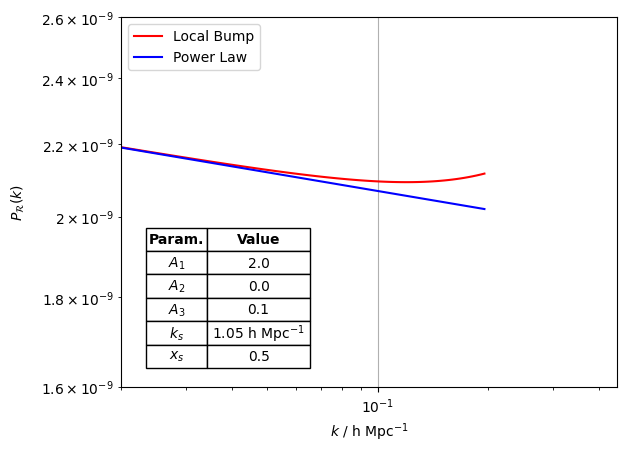

In [169]:
#Individual plot of the local bump feature with a table within its parameters inside:

plt.loglog(KhArrayJPAS, PrimordialLocalBumpFeature(KhArrayJPAS*hJPAS), color='red', label='Local Bump')
plt.loglog(KhArrayJPAS, PrimordialPowerLawNoh(AsJPAS, nsJPAS, KhArrayJPAS*hJPAS), color='blue', label='Power Law')
plt.xlabel(r'$k$ / h Mpc$^{-1}$')
plt.ylabel(r'$P_{\mathcal{R}}(k)$', labelpad=10)  # Adjust labelpad to increase space between label and axis
plt.grid(True)
plt.legend()

# Set the desired plot range and legend position
plt.xlim(2e-2, 0.45)  # Example range for the x-axis, adjust as needed
plt.ylim(1.6e-9, 2.6e-9)  # Example range for the y-axis, adjust as needed
plt.legend(loc='upper left')

# Define table data (transposed)
table_data = [
    ["Param.", "Value"],
    ["$A_1$", A1LBump],
    ["$A_2$", A2LBump],
    ["$A_3$", A3LBump],
    ["$k_s$", "1.05 h Mpc$^{-1}$"],
    ["$x_s$", xsLBump]
]

# Create and format the table with a larger size and specified position
table = plt.table(cellText=table_data, loc='upper right', cellLoc='center', bbox=[0.05, 0.05, 0.33, 0.38])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Set column widths for vertical table
col_width = 0.1
table.auto_set_column_width([0, 1])
for i in range(len(table_data)):
    table[(i, 0)].set_width(col_width)

# Soften the edges of the table by changing the linestyle of each cell edge
for key, cell in table.get_celld().items():
    cell.set_linestyle('-')

# Set the header cells "Param." and "Value" to bold
font = FontProperties()
font.set_weight('bold')
for cell in table.get_celld().values():
    if cell.get_text().get_text() in ['Param.', 'Value']:
        cell.get_text().set_fontproperties(font)

# Save the plot as a PDF file
#plt.savefig('Local_Bump_Feature_ParamTable.pdf', bbox_inches='tight')  # Use bbox_inches='tight' to adjust the bounding box

plt.show()

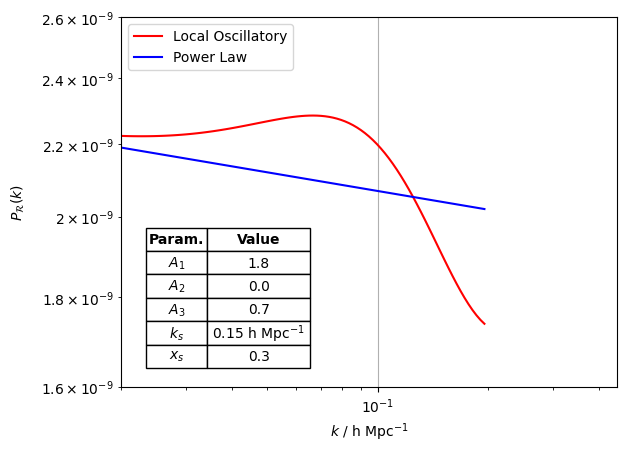

In [170]:
#Individual figure of the local oscillatory feature with a table within its parameters inside:

plt.loglog(KhArrayJPAS, PrimordialLocalOscillatoryFeature(KhArrayJPAS*hJPAS), color='red', label='Local Oscillatory')
plt.loglog(KhArrayJPAS, PrimordialPowerLawNoh(AsJPAS, nsJPAS, KhArrayJPAS*hJPAS), color='blue', label='Power Law')
plt.xlabel(r'$k$ / h Mpc$^{-1}$')
plt.ylabel(r'$P_{\mathcal{R}}(k)$', labelpad=10)  # Adjust labelpad to increase space between label and axis
plt.grid(True)
plt.legend()

# Set the desired plot range and legend position
plt.xlim(2e-2, 0.45)  # Example range for the x-axis, adjust as needed
plt.ylim(1.6e-9, 2.6e-9)  # Example range for the y-axis, adjust as needed
plt.legend(loc='upper left')

# Define table data (transposed)
table_data = [
    ["Param.", "Value"],
    ["$A_1$", A1LOsci],
    ["$A_2$", A2LOsci],
    ["$A_3$", A3LOsci],
    ["$k_s$", "0.15 h Mpc$^{-1}$"],
    ["$x_s$", xsLOsci]
]

# Create and format the table with a larger size and specified position
table = plt.table(cellText=table_data, loc='upper right', cellLoc='center', bbox=[0.05, 0.05, 0.33, 0.38])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Set column widths for vertical table
col_width = 0.1
table.auto_set_column_width([0, 1])
for i in range(len(table_data)):
    table[(i, 0)].set_width(col_width)

# Soften the edges of the table by changing the linestyle of each cell edge
for key, cell in table.get_celld().items():
    cell.set_linestyle('-')

# Set the header cells "Param." and "Value" to bold
font = FontProperties()
font.set_weight('bold')
for cell in table.get_celld().values():
    if cell.get_text().get_text() in ['Param.', 'Value']:
        cell.get_text().set_fontproperties(font)

# Save the plot as a PDF file
#plt.savefig('Local_Oscillatory_Feature_ParamTable.pdf', bbox_inches='tight')  # Use bbox_inches='tight' to adjust the bounding box

plt.show()

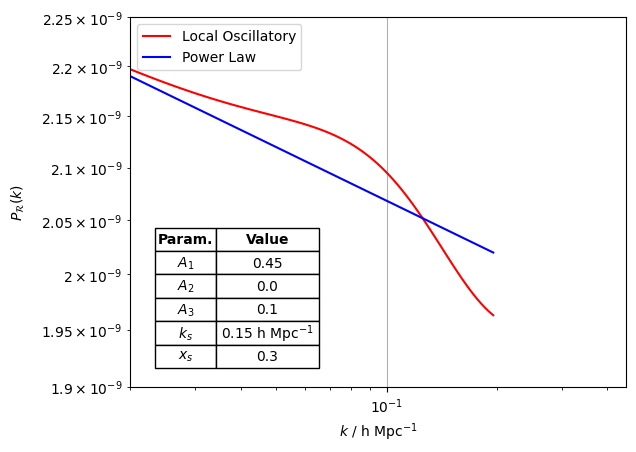

In [171]:
#Individual figure of the local oscillatory 3% feature with a table within its parameters inside:

plt.loglog(KhArrayJPAS, PrimordialLocalOscillatory3Feature(KhArrayJPAS*hJPAS), color='red', label='Local Oscillatory')
plt.loglog(KhArrayJPAS, PrimordialPowerLawNoh(AsJPAS, nsJPAS, KhArrayJPAS*hJPAS), color='blue', label='Power Law')
plt.xlabel(r'$k$ / h Mpc$^{-1}$')
plt.ylabel(r'$P_{\mathcal{R}}(k)$', labelpad=10)  # Adjust labelpad to increase space between label and axis
plt.grid(True)
plt.legend()

# Set the desired plot range and legend position
plt.xlim(2e-2, 0.45)  # Example range for the x-axis, adjust as needed
plt.ylim(1.9e-9, 2.25e-9)  # Example range for the y-axis, adjust as needed
plt.legend(loc='upper left')

# Define table data (transposed)
table_data = [
    ["Param.", "Value"],
    ["$A_1$", A1LO3sci],
    ["$A_2$", A2LO3sci],
    ["$A_3$", round(A3LO3sci,2)],
    ["$k_s$", "0.15 h Mpc$^{-1}$"],
    ["$x_s$", xsLO3sci]
]

# Create and format the table with a larger size and specified position
table = plt.table(cellText=table_data, loc='upper right', cellLoc='center', bbox=[0.05, 0.05, 0.33, 0.38])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Set column widths for vertical table
col_width = 0.1
table.auto_set_column_width([0, 1])
for i in range(len(table_data)):
    table[(i, 0)].set_width(col_width)

# Soften the edges of the table by changing the linestyle of each cell edge
for key, cell in table.get_celld().items():
    cell.set_linestyle('-')

# Set the header cells "Param." and "Value" to bold
font = FontProperties()
font.set_weight('bold')
for cell in table.get_celld().values():
    if cell.get_text().get_text() in ['Param.', 'Value']:
        cell.get_text().set_fontproperties(font)

# Save the plot as a PDF file
#plt.savefig('Local_Oscillatory_Feature_ParamTable.pdf', bbox_inches='tight')  # Use bbox_inches='tight' to adjust the bounding box

plt.show()

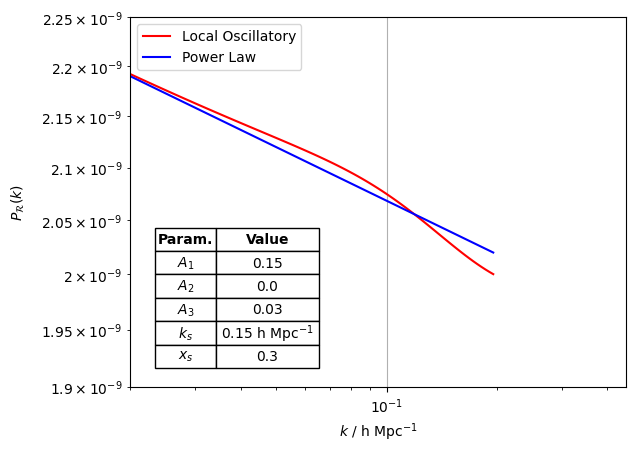

In [172]:
#Individual figure of the local oscillatory 1% feature with a table within its parameters inside:

plt.loglog(KhArrayJPAS, PrimordialLocalOscillatory1Feature(KhArrayJPAS*hJPAS), color='red', label='Local Oscillatory')
plt.loglog(KhArrayJPAS, PrimordialPowerLawNoh(AsJPAS, nsJPAS, KhArrayJPAS*hJPAS), color='blue', label='Power Law')
plt.xlabel(r'$k$ / h Mpc$^{-1}$')
plt.ylabel(r'$P_{\mathcal{R}}(k)$', labelpad=10)  # Adjust labelpad to increase space between label and axis
plt.grid(True)
plt.legend()

# Set the desired plot range and legend position
plt.xlim(2e-2, 0.45)  # Example range for the x-axis, adjust as needed
plt.ylim(1.9e-9, 2.25e-9)  # Example range for the y-axis, adjust as needed
plt.legend(loc='upper left')

# Define table data (transposed)
table_data = [
    ["Param.", "Value"],
    ["$A_1$", A1LO1sci],
    ["$A_2$", A2LO1sci],
    ["$A_3$", round(A3LO1sci,2)],
    ["$k_s$", "0.15 h Mpc$^{-1}$"],
    ["$x_s$", xsLO1sci]
]

# Create and format the table with a larger size and specified position
table = plt.table(cellText=table_data, loc='upper right', cellLoc='center', bbox=[0.05, 0.05, 0.33, 0.38])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Set column widths for vertical table
col_width = 0.1
table.auto_set_column_width([0, 1])
for i in range(len(table_data)):
    table[(i, 0)].set_width(col_width)

# Soften the edges of the table by changing the linestyle of each cell edge
for key, cell in table.get_celld().items():
    cell.set_linestyle('-')

# Set the header cells "Param." and "Value" to bold
font = FontProperties()
font.set_weight('bold')
for cell in table.get_celld().values():
    if cell.get_text().get_text() in ['Param.', 'Value']:
        cell.get_text().set_fontproperties(font)

# Save the plot as a PDF file
#plt.savefig('Local_Oscillatory_Feature_ParamTable.pdf', bbox_inches='tight')  # Use bbox_inches='tight' to adjust the bounding box

plt.show()

# Global feature template #

In [173]:
#Generic global oscillatory feature template:

def PrimordialGlobalFeature(As,ns,k,Alog,wlog,philog):
    return PrimordialPowerLawNoh(As,ns,k) * (1 + Alog*np.cos(wlog*np.log(k/(0.05/hJPAS))+philog))

In [174]:
#Parameters fixed in the global feature template:
wlogG = 4.0; philogG = 0;

In [175]:
#Thrre different amplitudes of the global oscillatory feature:
AlogGStrong = 0.1; AlogGMedium = 0.025; AlogGWeak = 0.0125;

In [176]:
#Template of 10% amplitude deviations:
def PrimordialGlobalStrongFeature(k):
    return PrimordialGlobalFeature(AsJPAS,nsJPAS,k,AlogGStrong,wlogG,philogG)

In [177]:
#Template of 2.5% amplitude deviations:
def PrimordialGlobalMediumFeature(k):
    return PrimordialGlobalFeature(AsJPAS,nsJPAS,k,AlogGMedium,wlogG,philogG)

In [178]:
#Template of 1.25% amplitude deviations:
def PrimordialGlobalWeakFeature(k):
    return PrimordialGlobalFeature(AsJPAS,nsJPAS,k,AlogGWeak,wlogG,philogG)

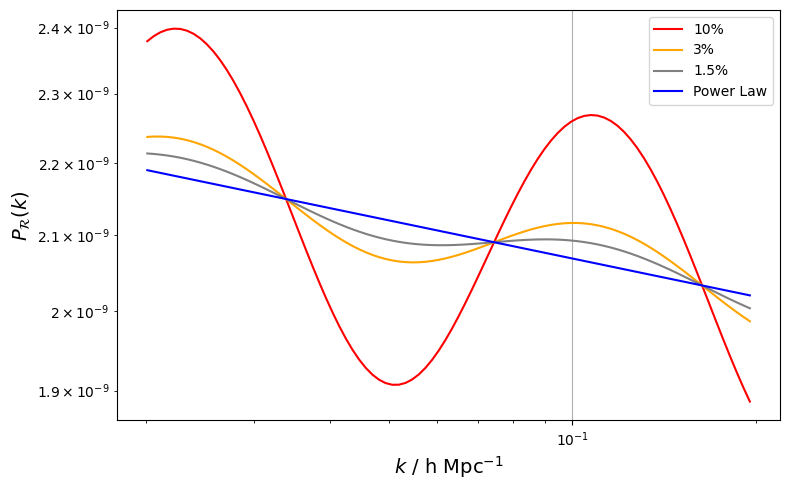

In [179]:
#Figure of the global oscillatory features explored:

plt.figure(figsize=(8, 5))  # Adjust the figure size as per your preference
plt.loglog(KhArrayJPAS, PrimordialGlobalStrongFeature(KhArrayJPAS*hJPAS), color='red', label='10%')
plt.loglog(KhArrayJPAS, PrimordialGlobalMediumFeature(KhArrayJPAS*hJPAS), color='Orange', label='3%')
plt.loglog(KhArrayJPAS, PrimordialGlobalWeakFeature(KhArrayJPAS*hJPAS), color='Gray', label='1.5%')
plt.loglog(KhArrayJPAS, PrimordialPowerLawNoh(AsJPAS, nsJPAS, KhArrayJPAS*hJPAS), color='blue', label='Power Law')
plt.xlabel(r'$k$ / h Mpc$^{-1}$', fontsize=14)  # Adjust the font size as per your preference
plt.ylabel(r'$P_{\mathcal{R}}(k)$', fontsize=14)  # Adjust the font size as per your preference
plt.grid(True)
plt.legend()
plt.tight_layout()
#plt.savefig('Global_Features.pdf')  # Save as PDF
plt.show()

# Computation of P_g^0(k)* #

In [180]:
#Construction of the linear matter power spectrum for the power law or other template (selection needed)*:

def PmLinearJPAS(k,iz):
    #return hJPAS**4*(2 * np.pi**2 * k * (interp1d(khJPASCAMB, TransTotJPAS[iz], kind='linear')(k))**2) * PrimordialPowerLaw(AsJPAS,nsJPAS,k)
    return hJPAS**4*(2 * np.pi**2 * k * (interp1d(khJPASCAMB, TransTotJPAS[iz], kind='linear')(k))**2) * PrimordialLocalOscillatoryFeature(k*hJPAS)

In [181]:
#Photometric error factor sigma_fid. It varies with the sampler since HJPAS depends on cosmoligcal parameters.
sigmaFidJPAS = DeltazLRGJPAS*(1+zJPAS)/HJPAS

In [182]:
#Fingers of God Factors at each redshift bin z:
def FFogJPAS(mu,k,iz):
    return 1/(1+(fJPASFid[iz]*k*mu*sigmapJPASFid[iz])**2)

In [183]:
#No Alcock Pazchisky effect neccesary for simulate the data (assumed with fiducial cosmology)

In [184]:
#Galaxy power spectrum Pg(mu,k) with FoG and sourced with the power law:

def PgJPAS(mu,k,iz): #k in h Mpc^{-1} units
    return FFogJPAS(mu,k,iz)*(bLRGJPAS[iz]+fJPASFid[iz]*mu**2)**2 * (PmLinearJPAS(k,iz)) *np.exp(-(k*mu*sigmaFidJPAS[iz])**2)                                                                                                                                                                                              

In [185]:
#Monopole galaxy power spectrum:

#Trapezoid rule with 2M steps for computing the Pmonopole(k)
def PgmonopoleJPAS(k,iz):
    mu = np.arange(-1, 1, 1/1000000)
    return 1/2 * integrate.trapz(PgJPAS(mu, k, iz), mu)

In [186]:
# Quadrupole galaxy power spectrum:

#Trapezoid rule with 2M steps for computing the Pmonopole(k)
def PgquadrupoleJPAS(k,iz):
    mu = np.arange(-1, 1, 1/1000000)
    return 5/2 * integrate.trapz(PgJPAS(mu, k, iz) * 0.5 * (3*mu**2-1), mu)

In [187]:
#This will initialize the Monopole at each z-bin
PgmonopoleJPASAtz = []

#Loop over the z-bins of the catalogue. 
for iz in range(len(zJPASPrevious)):
    PgmonopoleJPASAtz_iz = []
    #Calculate the monopole power spectrum at each k value
    for k in KhArrayJPAS:
        PgmonopoleJPASAtz_iz.append(PgmonopoleJPAS(k, int(2*iz+1))) #Properly link iz 0 with the the first element, iz 1 with the third...
    # Append the power spectra array to the main list
    PgmonopoleJPASAtz.append(PgmonopoleJPASAtz_iz)

In [188]:
#This will initialize the Quadrupole at each z-bin
PgquadrupoleJPASAtz = []

#Loop over the z-bins of the catalogue. 
for iz in range(len(zJPASPrevious)):
    PgquadrupoleJPASAtz_iz = []
    #Calculate the quadrupole power spectrum at each k value
    for k in KhArrayJPAS:
        PgquadrupoleJPASAtz_iz.append(PgquadrupoleJPAS(k, int(2*iz+1))) #Properly link iz 0 with the the first element, iz 1 with the third...
    # Append the power spectra array to the main list
    PgquadrupoleJPASAtz.append(PgquadrupoleJPASAtz_iz)

# Computation of Covariance Matrix #

In [189]:
#Sampling variance terms.

#Angular distance for z upper and lower bins. Already in h units:
XiZJPASLower = XiJPASFid[positions_Lower]
XiZJPASUpper = XiJPASFid[positions_Upper]

In [190]:
#Definition of the volume between redshift bins:
VolJPAS = 4*np.pi*fskyJPAS/3*(XiZJPASUpper**3-XiZJPASLower**3)

In [191]:
#Number of modes. It depends of ksup and kinf corresponding to kupper y klower, and the redshift bin iz:

def NkJPAS(ksup,kinf,iz):
    return VolJPAS[iz] * (4*np.pi/3*(ksup**3-kinf**3))/((2*np.pi)**3)

#Nk evaluated for each of our k-bins. Densities are red from self.data['ndz].
NkJPASEvaluated = np.zeros((len(zJPASPrevious), len(KhArrayJPAS)))

for iz in range(0, len(zJPASPrevious)):
    for j in range(0, len(KhArrayJPAS)):
        NkJPASEvaluated[iz][j] = NkJPAS(KhArrayJPASUpper[j],KhArrayJPASLower[j],iz)  

In [192]:
#Covariance, for the monopole and quadrupole, evaluated at our k array. Need to read the inverse densities as shot noise term:
CovMonopoleJPASEvaluated = np.zeros((len(zJPASPrevious), len(KhArrayJPAS)))
CovQuadrupoleJPASEvaluated = np.zeros((len(zJPASPrevious), len(KhArrayJPAS)))

for iz in range(0, len(zJPASPrevious)):
    for j in range(0, len(KhArrayJPAS)):
        CovMonopoleJPASEvaluated[iz][j] = 2 *(PgmonopoleJPASAtz[iz][j] + 1/nLRGsJPAS[iz])**2 / NkJPASEvaluated[iz][j]
        CovQuadrupoleJPASEvaluated[iz][j] = 2 *(PgquadrupoleJPASAtz[iz][j] + 1/nLRGsJPAS[iz])**2 / NkJPASEvaluated[iz][j]

# Realization of P_g^0 (monopole) with error bars for all redshift bins #

In [193]:
#Here a random seed gaussian(0,1) can be generated.
#SeedLRGJPAS = np.random.randn(len(KhArrayJPAS))

In [194]:
#In this notebook a previous seed is stored:

SeedLRGJPAS = np.array([ 1.74799979,  0.39542315, -0.60739112,  0.13344044,  0.77736593,
       -1.04422706, -0.43519356, -0.13997816,  1.10158213, -1.24535119,
       -0.06105025,  0.07283944,  0.54620229,  0.41621091,  0.5555711 ,
        0.17441658, -0.32996276, -0.86666344,  0.80128937,  0.10576746,
        1.09864816,  1.80382373, -0.87841256, -1.37789577,  0.94368332,
       -1.01125887,  0.09508169,  0.95883731,  1.50854103, -1.44109437,
       -1.2027443 ,  0.26067298, -0.7031966 , -0.6190492 , -0.01926801,
        0.22167703, -0.05314808,  0.51187477,  0.79796328, -0.07573841,
       -0.06818476,  0.3681958 , -1.30825327, -1.84606323,  0.31394095,
        0.44230079, -0.38360521, -1.91017653,  0.27541484,  1.45657982,
       -1.11058081,  1.48974317,  1.07375593,  1.4276276 , -0.86270571,
        0.26094022, -1.94784761,  1.69699882, -0.46591359, -0.76875473,
        0.88003892,  0.68055955,  1.15871761,  0.51453588, -0.57190551,
       -0.37047383, -0.69198254,  1.05103321, -0.34564968,  1.52731158,
        0.14281959, -1.00016756,  1.34725009, -0.75547588, -1.35016267,
        0.26631133,  0.28921862, -1.11046185,  0.38311775,  0.17576679,
        0.84523027,  0.48360502,  0.52942067, -0.4985066 ,  0.32854791,
        0.26869375,  1.00123923, -1.76929229, -0.97037779, -0.90666924,
       -1.28300699, -0.43362828])

In [195]:
#Realizations of the monopole and quadrupole with the sqrt(Cov) as error bars and Seed gaussian(0,1) deviations:

PgMonopoleRealizationLRGJPAS = np.zeros((len(zJPASPrevious), len(KhArrayJPAS)))
PgQuadrupoleRealizationLRGJPAS = np.zeros((len(zJPASPrevious), len(KhArrayJPAS)))

for iz in range(0, len(zJPASPrevious)):
    for j in range(0, len(KhArrayJPAS)):
        PgMonopoleRealizationLRGJPAS[iz][j] = PgmonopoleJPASAtz[iz][j] + SeedLRGJPAS[j]*np.sqrt(CovMonopoleJPASEvaluated[iz][j])
        PgQuadrupoleRealizationLRGJPAS[iz][j] = PgquadrupoleJPASAtz[iz][j] + SeedLRGJPAS[j]*np.sqrt(CovQuadrupoleJPASEvaluated[iz][j])

# Representation of realization of P_g^(0)(k,z)** #

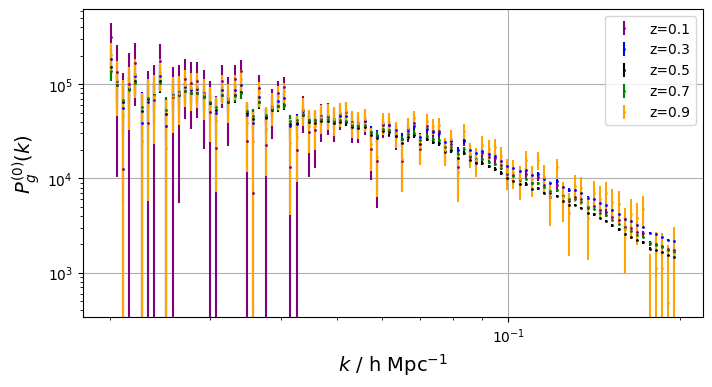

In [196]:
#Plot of the monopole galaxy power spectrum for all the z-bins.

# Define colors for different redshifz bins:
colorsJPASLRG = ['purple', 'blue', 'black', 'green', 'orange']

# Asign the error bars as the sqrt of Covariance Matrix:
ErrorBars = np.sqrt(CovMonopoleJPASEvaluated)

# Plot in log-log for each z-bin:
fig, ax = plt.subplots(figsize=(8, 4))
for iz in range(len(zJPASPrevious)):
    plt.errorbar(KhArrayJPAS, PgMonopoleRealizationLRGJPAS[iz], yerr=ErrorBars[iz], fmt='o', label=f"z={zJPAS[2*iz+1]:.1f}", color=colorsJPASLRG[iz], markersize=1)

#Plot options:
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ / h Mpc$^{-1}$', fontsize=14) 
plt.ylabel(r'$P_{g}^{(0)}(k)$', fontsize=14)  
plt.legend()
plt.grid(True)
#Save the name of the figure according to the specifications**:
plt.savefig('Simulated_PgMonopole_LRG_AllZBins_LO_LowDeltaZ_g12_5years.pdf', bbox_inches='tight')
plt.show()


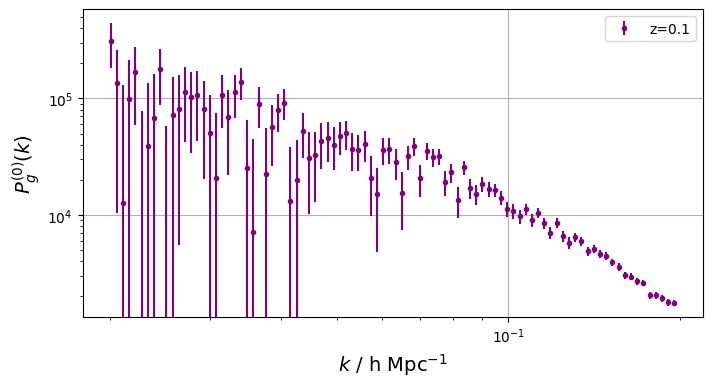

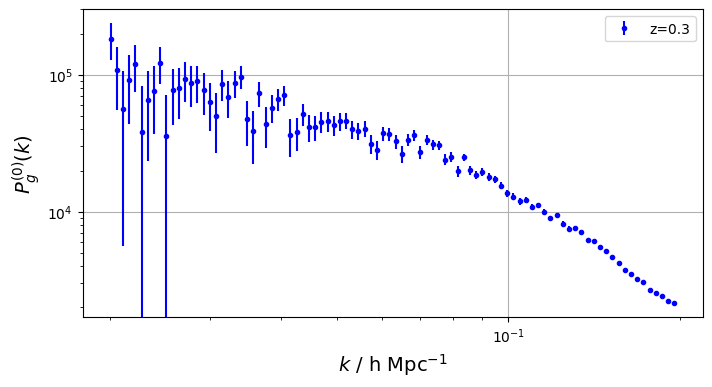

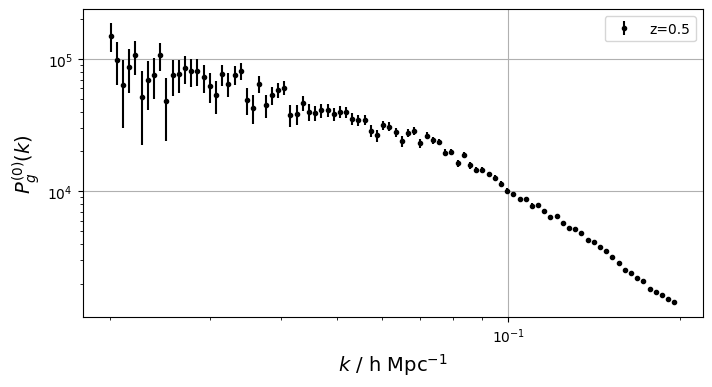

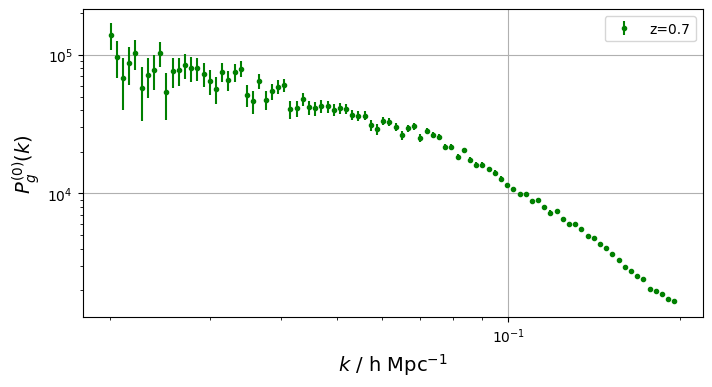

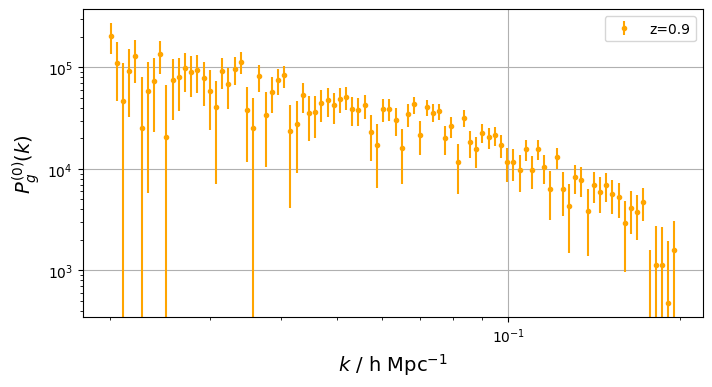

In [197]:
#A plot of the monopole galaxy power spectrum for each z-bin:

for iz in range(len(zJPASPrevious)):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Adjust index for the zJPAS array, assuming 2*iz+1 is correct for labeling
    plt.errorbar(KhArrayJPAS, PgMonopoleRealizationLRGJPAS[iz], yerr=ErrorBars[iz], fmt='o', 
                 label=f"z={zJPAS[2*iz+1]:.1f}", color=colorsJPASLRG[iz], markersize=3)
    
    # Plot options
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$k$ / h Mpc$^{-1}$', fontsize=14)
    plt.ylabel(r'$P_{g}^{(0)}(k)$', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Format the iz value to one decimal place
    z_value = 0.2 * iz + 0.1
    #Again, choose the name of the plot according to the specifications**
    filename = f'Simulated_PgMonopole_LRG_z{z_value:.1f}_LO_LowDeltaZ_g12_5years.pdf'
    
    # Save plot with the formatted filename
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

# Representation of realization of P_g^(2)(k,z)** #

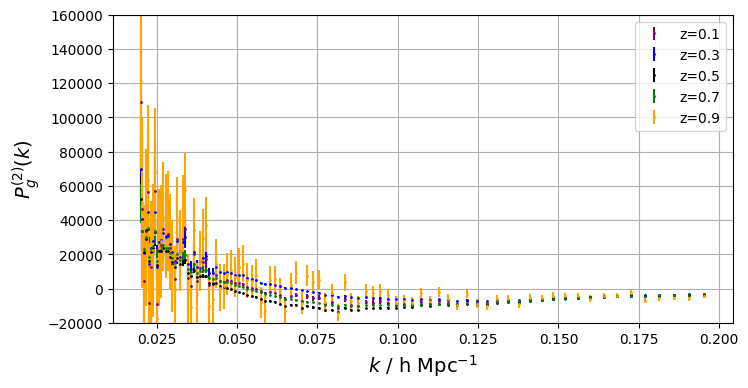

In [198]:
#Plot of the quadrupole galaxy power spectrum for all the z-bins.

# Assign the error bars as the sqrt of Covariance Matrix:
ErrorBars = np.sqrt(CovQuadrupoleJPASEvaluated)

# Plot in linear-linear for each z-bin:
fig, ax = plt.subplots(figsize=(8, 4))
for iz in range(len(zJPASPrevious)):
    plt.errorbar(KhArrayJPAS, PgQuadrupoleRealizationLRGJPAS[iz], yerr=ErrorBars[iz], fmt='o', label=f"z={zJPAS[2*iz+1]:.1f}", color=colorsJPASLRG[iz], markersize=1)

# Plot options:
plt.xscale('linear')  # Change x-axis to linear
plt.yscale('linear')  # Change y-axis to linear
plt.ylim([-20000, 160000])  # Set y-axis range
plt.xlabel(r'$k$ / h Mpc$^{-1}$', fontsize=14) 
plt.ylabel(r'$P_{g}^{(2)}(k)$', fontsize=14)  
plt.legend()
plt.grid(True)
#Match the name with the explored specifications**:
plt.savefig('Simulated_PgQuadrupole_LRG_AllZBins_LO_LowDeltaZ_g12_5years_linear.pdf', bbox_inches='tight')
plt.show()



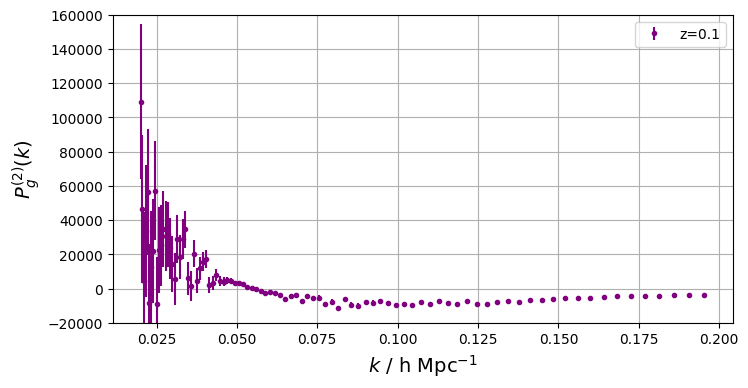

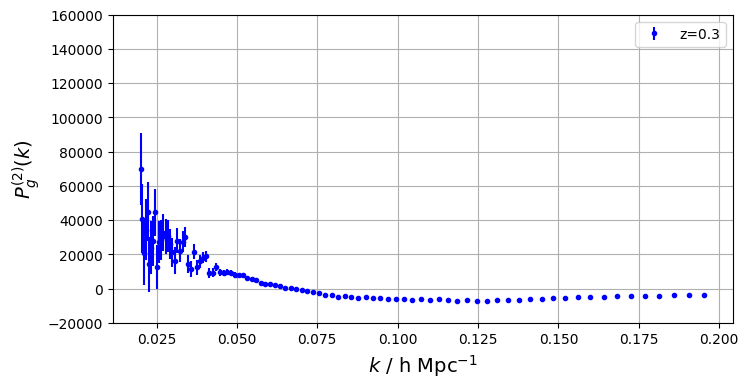

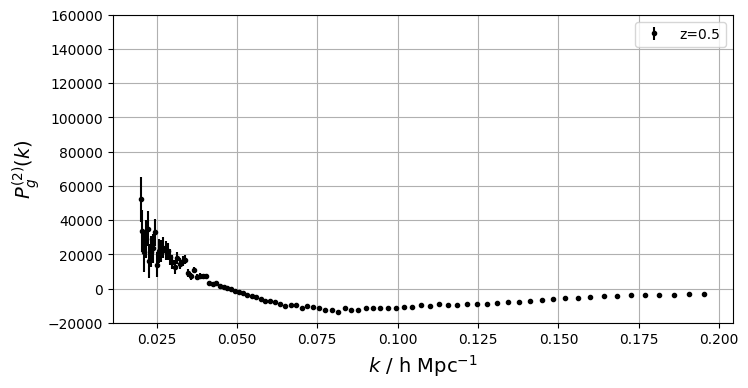

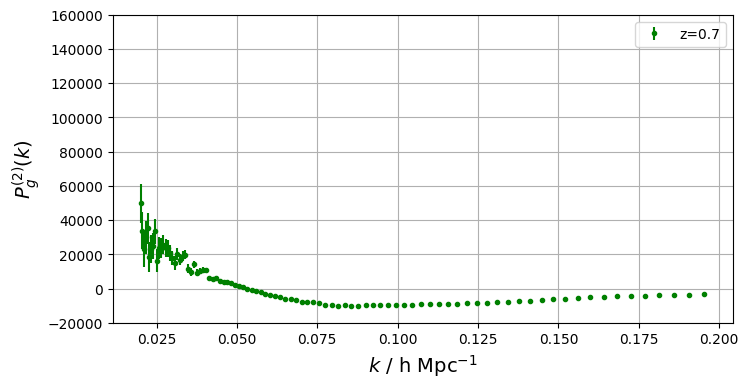

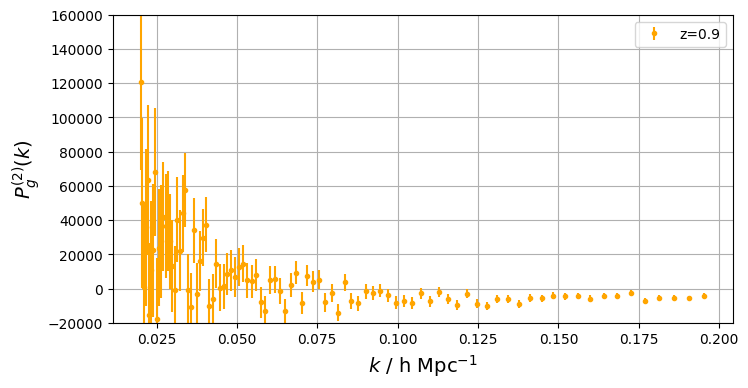

In [199]:
#A plot of the monopole galaxy power spectrum for each z-bin:

for iz in range(len(zJPASPrevious)):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Adjust index for the zJPAS array, assuming 2*iz+1 is correct for labeling
    plt.errorbar(KhArrayJPAS, PgQuadrupoleRealizationLRGJPAS[iz], yerr=ErrorBars[iz], fmt='o', 
                 label=f"z={zJPAS[2*iz+1]:.1f}", color=colorsJPASLRG[iz], markersize=3)
    
    # Plot options
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel(r'$k$ / h Mpc$^{-1}$', fontsize=14)
    plt.ylabel(r'$P_{g}^{(2)}(k)$', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Set the y-axis range explicitly to -100000 to 180000
    plt.ylim(-20000, 160000)
    
    # Format the iz value to one decimal place
    z_value = 0.2 * iz + 0.1
    #Match the filename with the specifications
    filename = f'Simulated_PgQuadrupole_LRG_z{z_value:.1f}_LO_LowDeltaZ_g12_5years.pdf'
    
    # Save plot with the formatted filename
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


# S/N for the mean monopole and quadrupole values** #

In [200]:
#Signal-to-noise of the LRG mono/quadrupole galaxy power spectra:

SNJMonopolePASLRG = np.zeros((len(zJPASPrevious), len(KhArrayJPAS)))
SNQuadrupoleJPASLRG = np.zeros((len(zJPASPrevious), len(KhArrayJPAS)))

for iz in range(0, len(zJPASPrevious)):
    for j in range(0, len(KhArrayJPAS)):
        SNJMonopolePASLRG[iz][j] = PgmonopoleJPASAtz[iz][j]/np.sqrt(CovMonopoleJPASEvaluated[iz][j])
        SNQuadrupoleJPASLRG[iz][j] = np.abs(PgquadrupoleJPASAtz[iz][j])/np.sqrt(CovQuadrupoleJPASEvaluated[iz][j])

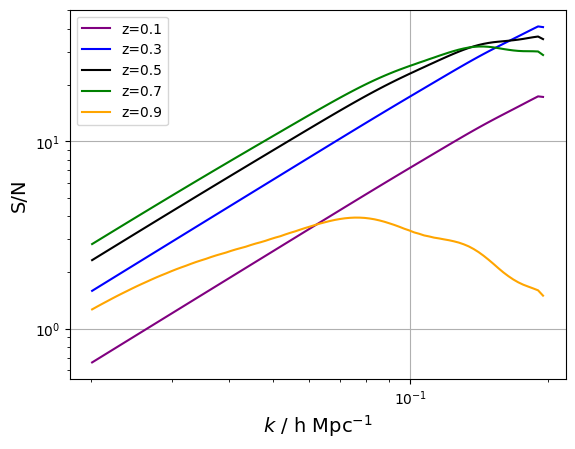

In [201]:
#Representation of the SN for the monopole

#Colors already defined before.

# Plot S/N for each z-bin in loglog:
for iz in range(len(SNJMonopolePASLRG)):
    plt.loglog(KhArrayJPAS, SNJMonopolePASLRG[iz], label=f'z={0.1+0.2*iz:.1f}', color=colorsJPASLRG[iz])

# Add labels and legend
plt.xlabel(r'$k$ / h Mpc$^{-1}$', fontsize=14) 
plt.ylabel(r'S/N', fontsize=14) 
plt.legend()
plt.grid(True)

# Save the plot as a PDF. Match it with the specifications**
plt.savefig('SN_JPAS_LRG_LO_LowDeltaZ_g12_5years.pdf')

# Show plot
plt.show()

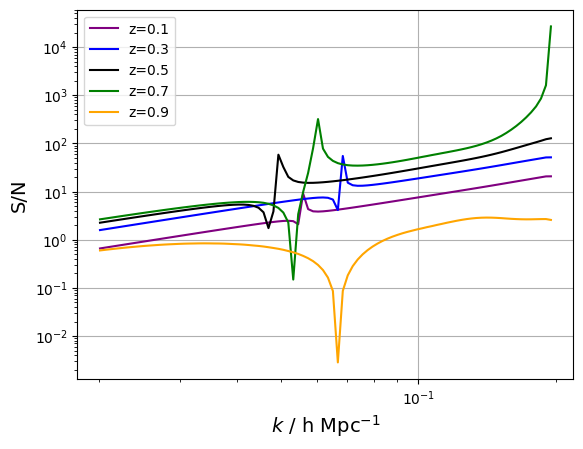

In [203]:
#Representation of the SN for the quadrupole.

# Plot S/N for each z-bin in loglog:
for iz in range(len(SNQuadrupoleJPASLRG)):
    plt.loglog(KhArrayJPAS, SNQuadrupoleJPASLRG[iz], label=f'z={0.1+0.2*iz:.1f}', color=colorsJPASLRG[iz])

# Add labels and legend
plt.xlabel(r'$k$ / h Mpc$^{-1}$', fontsize=14) 
plt.ylabel(r'S/N', fontsize=14) 
plt.legend()
plt.grid(True)

# Save the plot as a PDF. Match it with the specifications.
plt.savefig('SN_Quadrupole_JPAS_LRG_LO_LowDeltaZ_g12_5years.pdf')

# Show plot
plt.show()

# Exportation of used data for J-PAS LRG realizations* ** #

In [205]:
# Define the variables to be exported in the data files 'PAS_ForecastData_LRG_xxxxxxx' for each z-bin.
# Each column of each data file is:
#     - k-Array
#     - Primordial power spectrum evaluated at the k-array.
#     - Matter power spectrum evaluated at the k-array.
#     - Galaxy power spectrum evaluated at the k-array.
#     - Central monopole galaxy power spectrum at the k-array.
#     - Standard deviations of the monopole galaxy power spectrum.
#     - Seed employed in the realization, gaussian(0,1).
#     - Realization of the monopole galaxy power spectrum at the k-array.
#     - Central quadrupole galaxy power spectrum at the k-array.
#     - Standard deviations of the quadrupole galaxy power spectrum.
#     - Realization of the quadrupole galaxy power spectrum at the k-array.

kExport = KhArrayJPAS

#Select here the template of the primordial spectrum used*:

#PPSExport = PrimordialPowerLaw(AsJPAS, nsJPAS, KhArrayJPAS)
PPSExport = PrimordialLocalOscillatoryFeature(KhArrayJPAS*hJPAS)

MPSExport = np.array([PmLinearJPAS(KhArrayJPAS, 1+2*iz) for iz in range(len(zJPASPrevious))])
GPSmu0Export = np.array([PgJPAS(0,KhArrayJPAS, 1+2*iz) for iz in range(len(zJPASPrevious))]) #Evaluated at mu=0
MonopoleCentralExport = np.array([PgmonopoleJPASAtz[iz] for iz in range(len(zJPASPrevious))])
SqrtCovExport = np.array([CovMonopoleJPASEvaluated[iz] for iz in range(len(zJPASPrevious))])
SeedExport = SeedLRGJPAS
Pg0Export = np.array([PgmonopoleJPASAtz[iz] for iz in range(len(zJPASPrevious))])
QuadrupoleCentralExport = np.array([PgquadrupoleJPASAtz[iz] for iz in range(len(zJPASPrevious))])
SqrtCovQuadrupoleExport = np.array([CovQuadrupoleJPASEvaluated[iz] for iz in range(len(zJPASPrevious))])
Pg2Export = np.array([PgQuadrupoleRealizationLRGJPAS[iz] for iz in range(len(zJPASPrevious))])

# Define the headers if neccesary:
headers = ["k/h Mpc-1" "PPS", "MPS", "GPS mu 0", "Mean monopole", "sqrt(Cov)", "Seed", "Pg0", "Mean quadrupole", "sqrt(CovCuadru)", "Pg2"]

# Format the headers for good alignment
header_str = " ".join(f"{header:<15}" for header in headers)

# Combine the variables to be exported into an array of iz elements, each for each z-bin of interest for the LRGs. 
dataAllBins = np.array([np.column_stack((kExport, PPSExport, MPSExport[iz], GPSmu0Export[iz], MonopoleCentralExport[iz], SqrtCovExport[iz], SeedExport, Pg0Export[iz],QuadrupoleCentralExport[iz],SqrtCovQuadrupoleExport[iz],Pg2Export[iz])) for iz in range(len(zJPASPrevious))])

# Save the data in each file without the headers**:
for iz, dataBin in enumerate(dataAllBins, start=1):
    np.savetxt(f'JPAS_ForecastData_LRG_z{-0.1+0.2*iz:.1f}_LO_LowDeltaZ_g12_5years.dat', dataBin, fmt='%0.8e', delimiter='\t')